In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import torch
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import  layers, models 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import pickle
from sklearn.preprocessing import OneHotEncoder 
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from sklearn.neural_network import MLPClassifier
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras import backend as K
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# The **EMNIST** (Extended Modified National Institute of Standards and Technology) dataset is an extension of the MNIST dataset, containing handwritten character images. It comprises handwritten characters in various forms, such as **uppercase letters, lowercase letters, digits, and even some symbols.**

The dataset is organized into several different splits or subsets, each representing a different classification task:

* **ByClass:** Contains letters and digits. There are 814,255 characters in this dataset split.
* **ByMerge:** Similar to ByClass but with merged classes (e.g., uppercase 'C' and lowercase 'c' are considered the same). It contains 814,255 characters.
* **Balanced:** Contains a balanced set of characters for each class. There are 131,600 characters in this dataset split.
* **Letters:** Contains only letters. It consists of 145,600 characters.
* **Digits:** Contains only digits. It consists of 280,000 characters.

**Here we have used the balanced emnist dataset**

In [5]:
train_set = pd.read_csv("/kaggle/input/emnist/emnist-balanced-train.csv")
test_set = pd.read_csv("/kaggle/input/emnist/emnist-balanced-test.csv")

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46']


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: ylabel='count'>

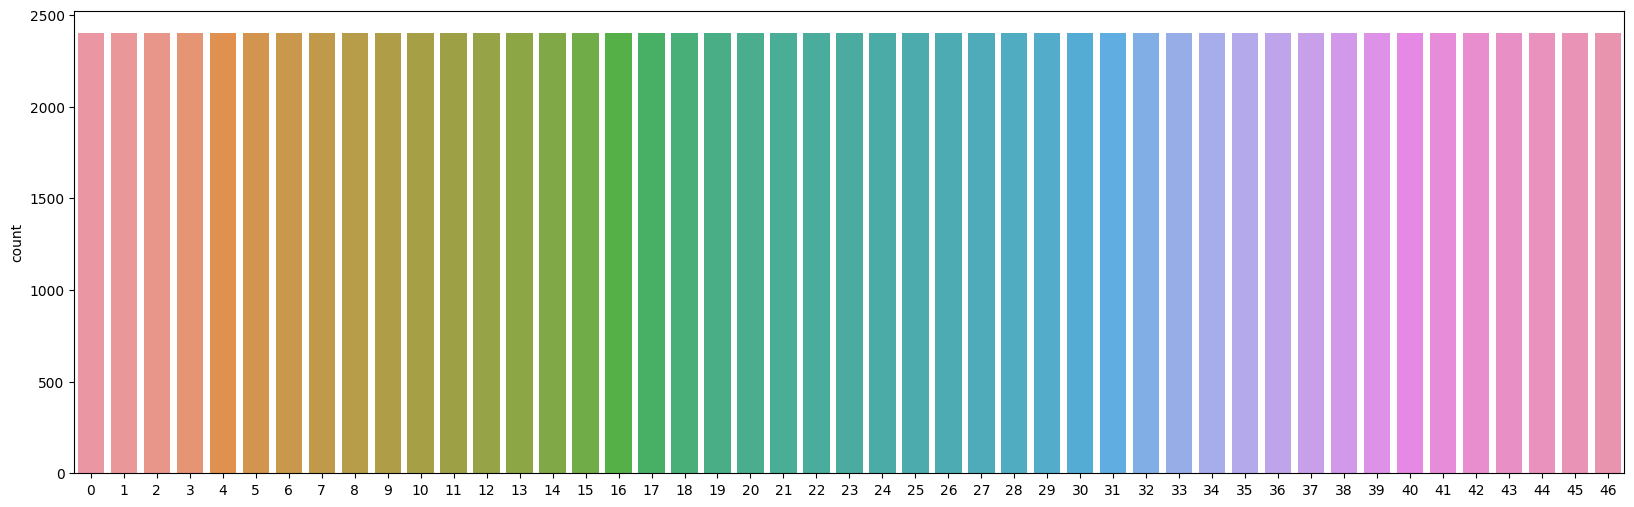

In [6]:
labels1 = train_set["45"].values
labels=set(labels1)
labels=list(labels)
labels = [str(label) for label in labels]
print(labels)

plt.figure(figsize=(20,6))
plt.plot()
sns.countplot(x=labels1)

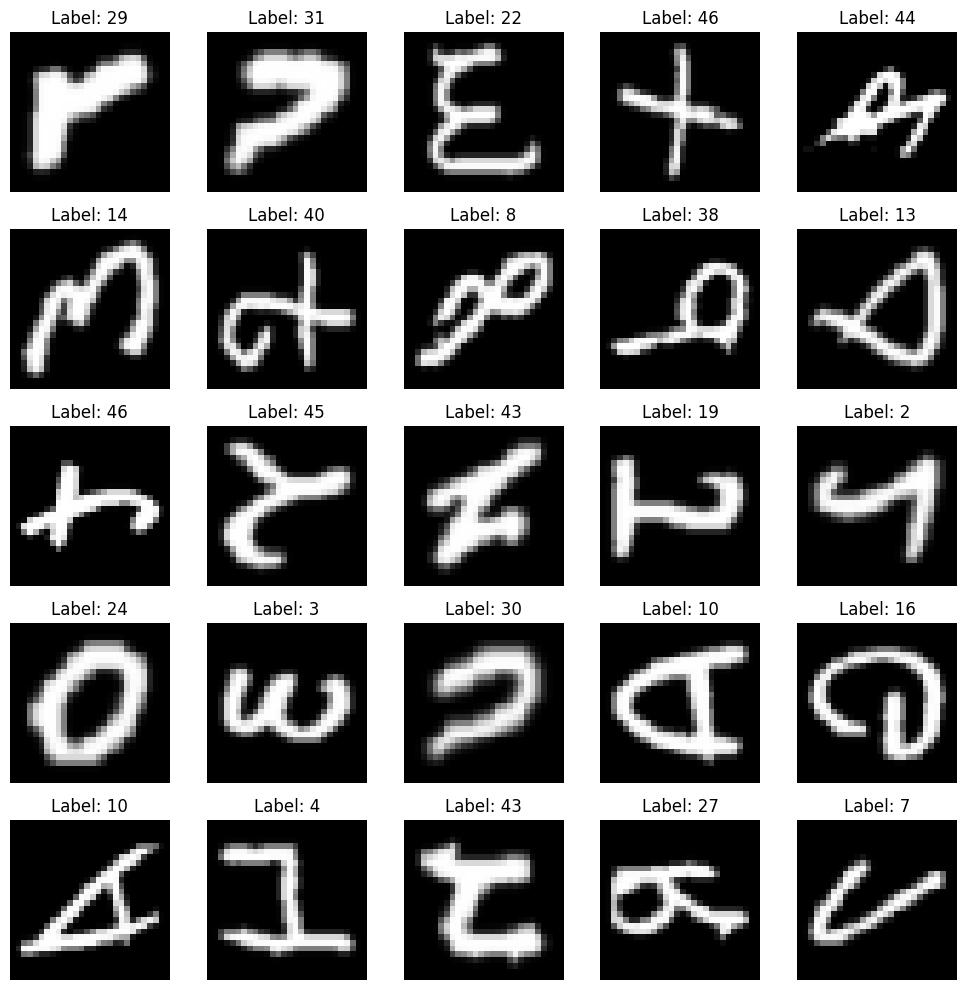

In [7]:
num_samples = 25 
selected_data = train_set.sample(n=num_samples)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    image = selected_data.iloc[i, 1:].values.reshape(28, 28)
    label = selected_data.iloc[i, 0]

    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
Y_train = np.array(train_set.iloc[:,0].values)
X_train = np.array(train_set.iloc[:,1:].values)
#test_set
Y_test = np.array(test_set.iloc[:,0].values)
X_test = np.array(test_set.iloc[:,1:].values)
print(Y_train.shape)
print(X_train.shape)

X_train= X_train/255
X_test= X_test/255

(112799,)
(112799, 784)


In [9]:
labels1 = train_set["45"].values
labels=set(labels1)
labels=list(labels)
labels = [str(label) for label in labels]
print(labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46']


In [10]:
Y_train=Y_train.ravel()
Y_test=Y_test.ravel()

In [11]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
x_train=X_train
y_train=Y_train
x_test=X_test
# Reshape the data to have a single color channel (since EMNIST is grayscale)
# and match the input shape expected by the model
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

# One-hot encode the target labels for categorical classification.
Y_train = tf.keras.utils.to_categorical(Y_train, 47)  # 37 classes (26 letters + 1 for 'none')
Y_test = tf.keras.utils.to_categorical(Y_test, 47)
print(x_test.shape)

(18799, 784)


### Using KNN on EMNIST Balanced Dataset:

K-Nearest Neighbors (KNN) is a versatile and straightforward algorithm used for classification tasks, including handwritten character recognition, such as the one present in the EMNIST balanced dataset.

1. **Algorithm Overview:**
   - **Classification Method:** KNN works by finding the 'k' nearest neighbors to a given data point based on similarity measures (like Euclidean distance) among features.
   - **Decision Making:** For example, when classifying a handwritten character in the EMNIST dataset, KNN looks at the 'k' most similar known characters from the dataset and assigns the majority class label among those neighbors to the unknown character.
   

2. **Application to EMNIST Balanced Dataset:**
   - **Data Representation:** EMNIST provides images of handwritten characters.
   - **Feature Extraction:** Before applying KNN, it's common to preprocess the images, converting them into feature vectors. For instance, flattening the images into 1D arrays or extracting relevant features.
   - **Training:** KNN doesn't involve explicit training. It stores the entire dataset as its "knowledge" and uses it directly during prediction.
   - **Prediction:** Given a new handwritten character (as an image or feature vector), KNN finds the 'k' most similar characters from the dataset and assigns a label based on majority voting among those neighbors.
   

3. **Considerations for KNN on EMNIST:**
   - **Feature Engineering:** Choosing appropriate features from the image data is crucial. Techniques like PCA or other dimensionality reduction methods can be applied to reduce feature dimensions.
   - **Parameter Tuning:** Selecting the optimal 'k' value and distance metric (such as Euclidean, Manhattan, etc.) can significantly affect the classifier's performance.
   - **Scalability:** The computational cost of KNN can increase with larger datasets due to its reliance on distance calculations for every new data point.
   

4. **Evaluation:**
   - **Cross-Validation:** To assess the performance of KNN on the EMNIST dataset, techniques like cross-validation can be used to measure metrics such as accuracy, precision, recall, and F1-score.
   

KNN is a relatively intuitive and easy-to-understand algorithm, making it suitable for initial exploration and baseline performance evaluation on the EMNIST dataset. However, optimizing parameters and handling larger datasets efficiently might require additional techniques to enhance its effectiveness.

**Let's break down what each part of the code is doing:**

**1. Initializing KNN Classifier:**

The code initializes a KNN classifier using KNeighborsClassifier from the scikit-learn library. It sets the number of neighbors to 7 (n_neighbors=7), uses distance-based weights (weights='distance'), and lets the algorithm decide the best method (algorithm='auto') for computation.

**2. Feature Extraction using PCA:**

PCA (Principal Component Analysis) is applied to the data (x_train) to reduce its dimensionality. It extracts 40 principal components from the data (n_components=40).
pca.fit(x_train, y_train) computes the principal components based on the training data.
pca.transform(x_train) and pca.transform(x_test) transform the training and test data into a lower-dimensional space using the computed principal components.

**3. Cross-validation and Evaluation:**

cross_val_score function from scikit-learn performs a 10-fold cross-validation on the training data (x_train_pca, y_train).
Evaluation metrics such as accuracy, precision, recall, and F1-score are calculated using different scoring methods (scoring='accuracy', 'precision_macro', 'recall_macro', 'f1_macro') during cross-validation.
np.mean() computes the average values of these evaluation metrics across all folds of the cross-validation.

**4. Runtime Measurement:**

The code measures the runtime of PCA (PCA runtime) and the overall KNN execution (KNN runtime) using Python's datetime module.

In [12]:
### Construct KNN model employment.
knn = KNeighborsClassifier(n_neighbors=7,
                           weights='distance',     #{distance, uniform}
                           algorithm = 'auto'
                           )  

In [13]:
# Apply PCA for feature extraction.
t0 = datetime.datetime.now()

pca = PCA(n_components=40)
pca.fit(x_train, y_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print(x_train_pca.shape)
print(y_train.shape)
to = datetime.datetime.now() - t0
print('PCA runtime:', to)
# execute the 10-fold cross validation exercise in training dataset.
t0 = datetime.datetime.now()

CV_accuracy_score = cross_val_score(knn, x_train_pca, y_train, cv=10, scoring = 'accuracy')
CV_precision_score = cross_val_score(knn,x_train_pca, y_train, cv=10, scoring = 'precision_macro')
CV_recall_score = cross_val_score(knn, x_train_pca, y_train, cv=10, scoring = 'recall_macro')
CV_f1_score = cross_val_score(knn, x_train_pca, y_train, cv=10, scoring = 'f1_macro')
average_accuracy = np.mean(CV_accuracy_score)
average_precision = np.mean(CV_precision_score)
average_recall = np.mean(CV_recall_score)
average_f1 = np.mean(CV_f1_score)

to = datetime.datetime.now() - t0
print('KNN runtime:', to)

(112799, 40)
(112799,)
PCA runtime: 0:00:04.051890
KNN runtime: 0:02:01.571901


In [14]:
print('average_accuracy:', average_accuracy)
print('average_precision:', average_precision)
print('average_recall:', average_recall)
print('average_f1:', average_f1)

average_accuracy: 0.8113457908974124
average_precision: 0.8144007270029222
average_recall: 0.811347035520342
average_f1: 0.8107768645439609


In [15]:
knn = knn.fit(x_train_pca, y_train)
pickle.dump(knn,open('model_knn.pkl','wb'))
knn_pkl = pickle.load(open('model_knn.pkl','rb'))
knn_pred=knn_pkl.predict(x_test_pca)
from sklearn.preprocessing import label_binarize

# Assuming knn_pred is a 1D array of predicted labels
knn_pred_multi_label = label_binarize(knn_pred, classes=range(47))

knn_accuracy = accuracy_score(Y_test, knn_pred_multi_label)*100

print("Accuracy for KNN {} %".format (knn_accuracy))
print(classification_report(Y_test, knn_pred_multi_label, target_names=labels))

Accuracy for KNN 81.18516942390552 %
              precision    recall  f1-score   support

           0       0.57      0.64      0.60       400
           1       0.49      0.59      0.54       400
           2       0.90      0.76      0.83       400
           3       0.94      0.95      0.95       400
           4       0.88      0.84      0.86       400
           5       0.87      0.75      0.81       400
           6       0.85      0.91      0.88       400
           7       0.92      0.98      0.95       400
           8       0.83      0.83      0.83       400
           9       0.60      0.77      0.68       400
          10       0.90      0.88      0.89       400
          11       0.88      0.81      0.85       400
          12       0.88      0.92      0.90       400
          13       0.87      0.81      0.83       400
          14       0.95      0.91      0.93       400
          15       0.58      0.54      0.56       400
          16       0.91      0.83      0.87 

# **ANN From Scratch on Digit Character Dataset**

This scratch implementation uses numPy and mathematics and defines functions for **forward propagation, backward propagation, parameter initialization, activation functions (ReLU and softmax), and training through gradient descent.**

### Overview of the Implementation:

1. **Initialization:** `init_params()` initializes the weights and biases for each layer in the neural network.

2. **Forward Propagation:** `forward_prop()` computes the forward pass through the network layers, applying ReLU activation in hidden layers and softmax in the output layer.

3. **Backward Propagation:** `backward_prop()` computes gradients using backpropagation, calculating derivatives of the loss function with respect to network parameters.

4. **Parameter Update:** `update_params()` updates the weights and biases using the calculated gradients and a learning rate (`alpha`).

5. **Model Training:** `gradient_descent()` performs iterations of forward and backward passes, updating parameters to minimize the loss function. It also prints accuracy and validation accuracy at regular intervals.

6. **Prediction and Testing:** `make_predictions()` generates predictions using the trained model, and `test_prediction()` showcases predictions and labels for specific indices in the training set. Additionally, it evaluates accuracy on the test set.

# Dataset Visualization

This dataset contains images of handwritten digits and letters from the English alphabet. It combines two popular datasets: the **MNIST dataset** and the **A_Z Handwritten Data dataset**.

The combined dataset has a **total of 442,450 images**, with a size of **28x28 pixels** and a **label column**.

The **label column has values from 0 to 35**, corresponding to the **digits 0 to 9 and the letters A to Z (where A is 10 and Z is 35)**.

The combined dataset is split into train and test sets, with the same proportions as the MNIST dataset. **The train set has the first 339,337 images and the test set has the last 103,113 images.**

In [16]:
df = pd.read_csv('/kaggle/input/digit-character/digit_char_dataset.csv')

In [17]:
X = df.drop('class',axis = 1)
y = df['class']

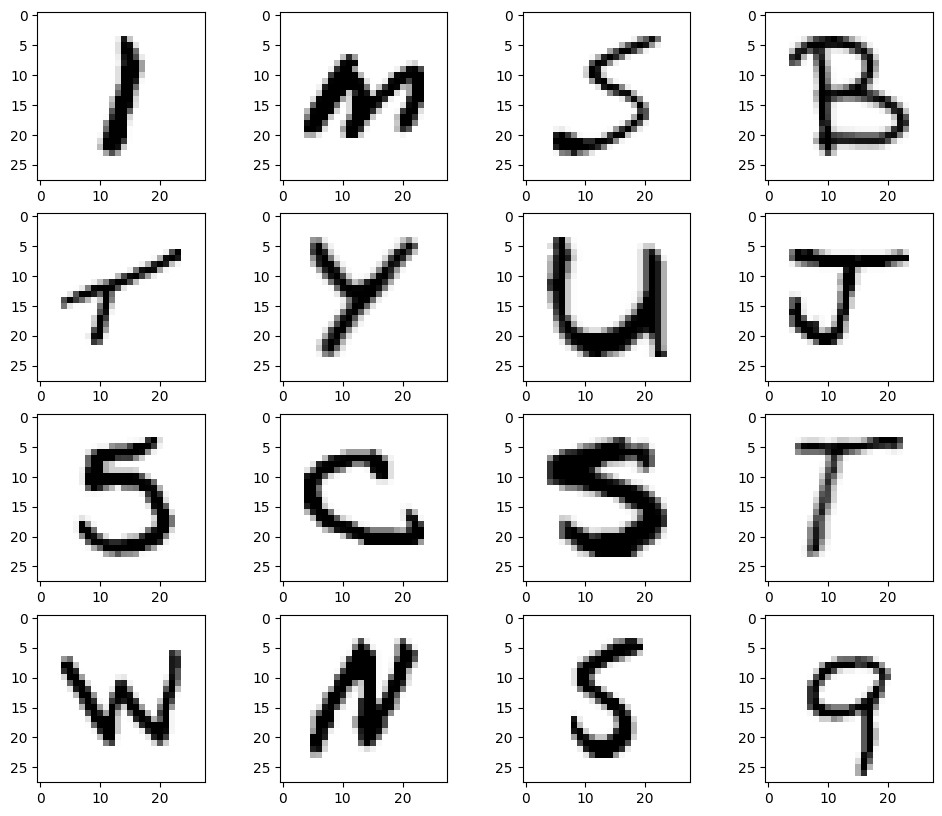

In [18]:
from sklearn.utils import shuffle

X_shuffle = shuffle(X)

plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_shuffle.iloc[i].values.reshape(28,28),interpolation='nearest', cmap='Greys')
plt.show()

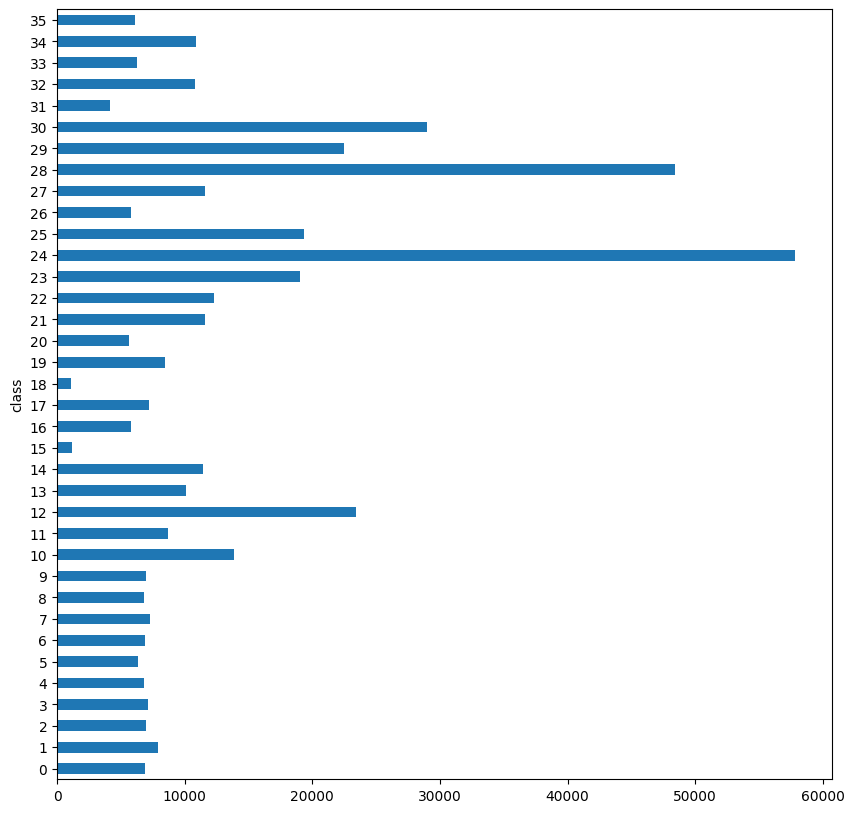

In [19]:
label_size = df.groupby('class').size()
label_size.plot.barh(figsize=(10,10))
plt.show()

In [20]:
df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21
442446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
442447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26
442448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29


In [21]:
data = np.array(df)
m, n = data.shape
np.random.shuffle(data)

data_test = data[0:12450].T
Y_test = data_test[n-1]
X_test = data_test[0:n-1]
X_test = X_test / 255.

data_train = data[12450:m].T
Y_train = data_train[n-1]
X_train = data_train[0:n-1]
X_train = X_train / 255.
_,m_train = X_train.shape

print(_, m_train)

784 430000


In [22]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(784, 430000)
(430000,)
(784, 12450)
(12450,)


In [23]:
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)
print(Y_train)
print(Y_test)

[10 29 10 ... 20 33 24]
[16 11 21 ... 29  8 24]


In [24]:
classes = []

for i in range(36):
    
    if i < 10:
        classes.append(chr(i+48))
    else:
        classes.append(chr(i-10+65))
        
classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [25]:
def init_params():
    
    W1 = np.random.rand(196, 784) - 0.5
    b1 = np.random.rand(196, 1) - 0.5
    
    W2 = np.random.rand(98, 196) - 0.5
    b2 = np.random.rand(98, 1) - 0.5
    
    W3 = np.random.rand(82, 98) - 0.5
    b3 = np.random.rand(82, 1) - 0.5

    W4 = np.random.rand(36, 82) - 0.5
    b4 = np.random.rand(36, 1) - 0.5
    
    return W1, b1, W2, b2, W3, b3, W4, b4

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X):
    
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    
    Z3 = W3.dot(A2) + b3
    A3 = ReLU(Z3)
    
    Z4 = W4.dot(A3) + b4
    A4 = softmax(Z4)
    
    return Z1, A1, Z2, A2, Z3, A3, Z4, A4

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, Z4, A4, W1, W2, W3, W4, X, Y):

    one_hot_Y = one_hot(Y)

    dZ4 = A4 - one_hot_Y
    dW4 = 1 / m * dZ4.dot(A3.T)
    db4 = 1 / m * np.sum(dZ4)
    
    dZ3 = W4.T.dot(dZ4) * ReLU_deriv(Z3)
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3)
    
    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    return dW1, db1, dW2, db2, dW3, db3, dW4, db4

def update_params(W1, b1, W2, b2, W3, b3, W4, b4, dW1, db1, dW2, db2, dW3, db3, dW4, db4, alpha):
    
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    
    W3 = W3 - alpha * dW3  
    b3 = b3 - alpha * db3    
    
    W4 = W4 - alpha * dW4  
    b4 = b4 - alpha * db4        
    
    return W1, b1, W2, b2, W3, b3, W4, b4

In [26]:
def get_predictions(A4):
    return np.argmax(A4, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3, W4, b4 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X)
        dW1, db1, dW2, db2, dW3, db3, dW4, db4 = backward_prop(Z1, A1, Z2, A2, Z3, A3, Z4, A4, W1, W2, W3, W4, X, Y)
        W1, b1, W2, b2, W3, b3, W4, b4 = update_params(W1, b1, W2, b2, W3, b3, W4, b4, dW1, db1, dW2, db2, dW3, db3, dW4, db4, alpha)
        if i % 50 == 0:
#             print("Iteration: ", i)
            predictions = get_predictions(A4)
            print("Accuracy : ", get_accuracy(predictions, Y))
            
            Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X_test)
            predictions = get_predictions(A4)
            print("Validation Accuracy : ", get_accuracy(predictions, Y_test))
            
            print('\n\n')
    return W1, b1, W2, b2, W3, b3, W4, b4

In [ ]:
# W1, b1, W2, b2, W3, b3, W4, b4 = gradient_descent(X_train, Y_train, 0.01, 2500)

In [27]:
def make_predictions(X, W1, b1, W2, b2, W3, b3, W4, b4):
    Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X)
    predictions = get_predictions(A4)
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3, W4, b4):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2, W3, b3, W4, b4)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [ ]:
# test_prediction(1, W1, b1, W2, b2, W3, b3, W4, b4)
# test_prediction(2, W1, b1, W2, b2, W3, b3, W4, b4)
# test_prediction(3, W1, b1, W2, b2, W3, b3, W4, b4)
# test_prediction(4, W1, b1, W2, b2, W3, b3, W4, b4)

In [ ]:
# test_predictions = make_predictions(X_test, W1, b1, W2, b2, W3, b3, W4, b4)
# get_accuracy(test_predictions, Y_test)

# ANN using Keras

In [28]:
X_train = X_train.T
X_train.shape

(430000, 784)

In [29]:
Y_train.shape

(430000,)

In [30]:
X_test = X_test.T
X_test.shape

(12450, 784)

In [31]:
Y_test.shape

(12450,)

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Activation, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import categorical _crossentropy
from keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix

import itertools

In [33]:
Y_train_encoded = to_categorical(Y_train, num_classes=36)
Y_test_encoded = to_categorical(Y_test, num_classes=36)

In [34]:
ann = Sequential([
    Dense(784, activation='relu', input_shape=(784,)),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(36, activation='softmax')
])

In [35]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 784)               615440    
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               401920    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 36)                9

In [36]:
ann.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [37]:
ann_fit=ann.fit(X_train, Y_train_encoded, epochs=10, validation_data=(X_test,Y_test_encoded))

Epoch 1/10
13438/13438 [==============================] - 49s 3ms/step - loss: 0.5810 - accuracy: 0.8418 - val_loss: 0.2243 - val_accuracy: 0.9388
Epoch 2/10
13438/13438 [==============================] - 45s 3ms/step - loss: 0.4298 - accuracy: 0.8892 - val_loss: 0.2033 - val_accuracy: 0.9453
Epoch 3/10
13438/13438 [==============================] - 45s 3ms/step - loss: 0.4150 - accuracy: 0.8968 - val_loss: 0.1940 - val_accuracy: 0.9511
Epoch 4/10
13438/13438 [==============================] - 45s 3ms/step - loss: 0.4069 - accuracy: 0.9014 - val_loss: 0.1903 - val_accuracy: 0.9501
Epoch 5/10
13438/13438 [==============================] - 45s 3ms/step - loss: 0.4055 - accuracy: 0.9046 - val_loss: 0.1848 - val_accuracy: 0.9522
Epoch 6/10
13438/13438 [==============================] - 45s 3ms/step - loss: 0.4029 - accuracy: 0.9063 - val_loss: 0.1954 - val_accuracy: 0.9509
Epoch 7/10
13438/13438 [==============================] - 45s 3ms/step - loss: 0.4031 - accuracy: 0.9077 - val_loss: 0

In [38]:
history = ann_fit.history

training_loss = history['loss']
validation_loss = history['val_loss']

training_accuracy = history['accuracy']
validation_accuracy = history['val_accuracy']


print("Training Loss:", training_loss)
print("Validation Loss:", validation_loss)
print("Training Accuracy:", training_accuracy)
print("Validation Accuracy:", validation_accuracy)

Training Loss: [0.5810379981994629, 0.4298263192176819, 0.4150063693523407, 0.40687572956085205, 0.40554365515708923, 0.4029477834701538, 0.4031383991241455, 0.40110093355178833, 0.4071246087551117, 0.41292303800582886]
Validation Loss: [0.22433869540691376, 0.20327207446098328, 0.19400127232074738, 0.19028188288211823, 0.18483960628509521, 0.19542838633060455, 0.19367066025733948, 0.2021150439977646, 0.1913469135761261, 0.1943415105342865]
Training Accuracy: [0.8418349027633667, 0.8891604542732239, 0.8968232274055481, 0.9014046788215637, 0.9045976996421814, 0.9063023328781128, 0.9076860547065735, 0.9086232781410217, 0.9087651371955872, 0.9090511798858643]
Validation Accuracy: [0.9387952089309692, 0.9453011751174927, 0.951084315776825, 0.9501205086708069, 0.9522088170051575, 0.9509236812591553, 0.9513252973556519, 0.9486746788024902, 0.9507630467414856, 0.950361430644989]


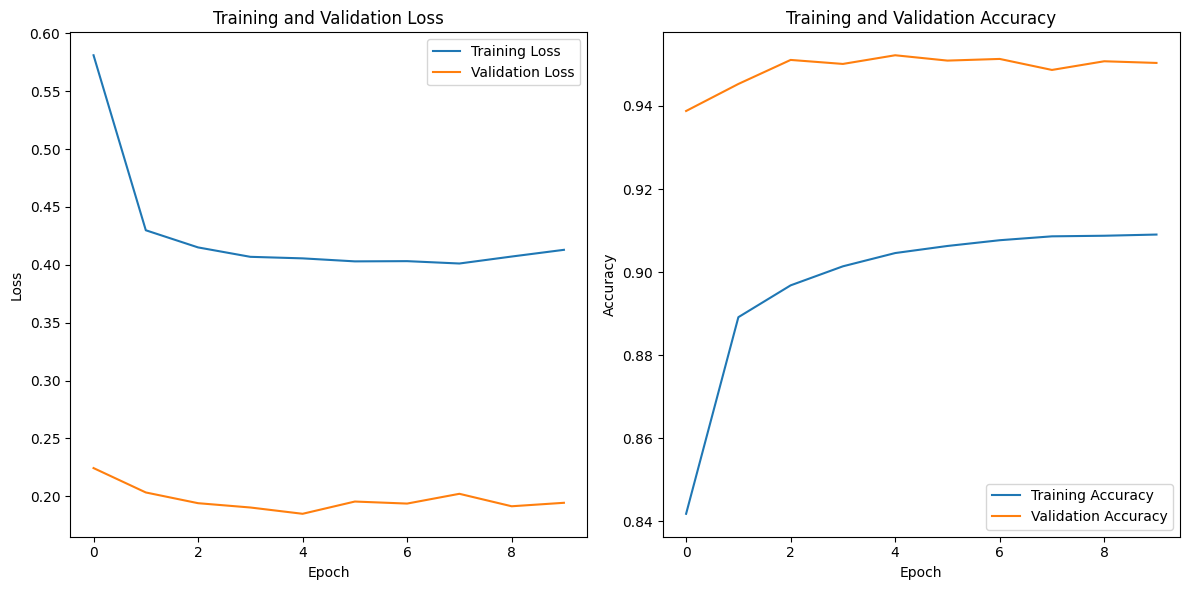

In [39]:
# Plotting the Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
predictions = ann.predict(X_test)
predictions

390/390 [==============================] - 1s 1ms/step


array([[1.71160558e-04, 2.16517666e-08, 2.36326270e-03, ...,
        1.38891855e-14, 7.47643440e-08, 3.38881545e-09],
       [5.99898107e-04, 1.92440965e-03, 1.86530985e-02, ...,
        8.58729146e-03, 7.54612219e-03, 2.95919217e-02],
       [9.20794818e-08, 2.73846965e-02, 1.03331078e-02, ...,
        4.02760535e-01, 6.91482276e-02, 3.18866968e-02],
       ...,
       [0.00000000e+00, 3.55055176e-34, 8.98572806e-36, ...,
        0.00000000e+00, 5.05528779e-13, 9.58376745e-30],
       [5.25585975e-08, 1.99406641e-04, 8.62385239e-03, ...,
        6.10572400e-12, 1.38355838e-09, 3.36331019e-10],
       [4.90081534e-02, 4.09794447e-05, 1.51981122e-03, ...,
        3.38281687e-08, 3.88363056e-04, 2.49495156e-06]], dtype=float32)

In [41]:
Y_test_pred = np.argmax(predictions, axis=1)

In [42]:
ann_accuracy = get_accuracy(Y_test_pred, Y_test)
ann_accuracy

[26 11 33 ... 29  8 24] [16 11 21 ... 29  8 24]


0.9503614457831325

In [43]:
cls_report = classification_report(Y_test, Y_test_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.98      0.59      0.73       176
           1       0.95      0.98      0.96       247
           2       0.95      0.92      0.94       197
           3       0.98      0.93      0.95       216
           4       0.94      0.95      0.94       202
           5       0.97      0.77      0.86       143
           6       0.98      0.98      0.98       188
           7       0.97      0.95      0.96       210
           8       0.98      0.87      0.92       187
           9       0.97      0.91      0.94       191
          10       0.91      0.98      0.94       393
          11       0.82      0.95      0.88       239
          12       0.97      0.97      0.97       707
          13       0.92      0.87      0.89       249
          14       0.98      0.88      0.93       339
          15       0.95      0.95      0.95        20
          16       0.96      0.89      0.92       176
          17       0.93    

In [44]:
cm = confusion_matrix(y_true = Y_test, y_pred = Y_test_pred)
cm

array([[103,   0,   0, ...,   0,   0,   0],
       [  0, 242,   2, ...,   0,   0,   0],
       [  0,   0, 182, ...,   0,   0,  10],
       ...,
       [  0,   0,   0, ..., 155,   1,   0],
       [  0,   2,   0, ...,   0, 280,   0],
       [  0,   0,   2, ...,   0,   0, 155]])

In [45]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    
    plt.figure(figsize=(23,23))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


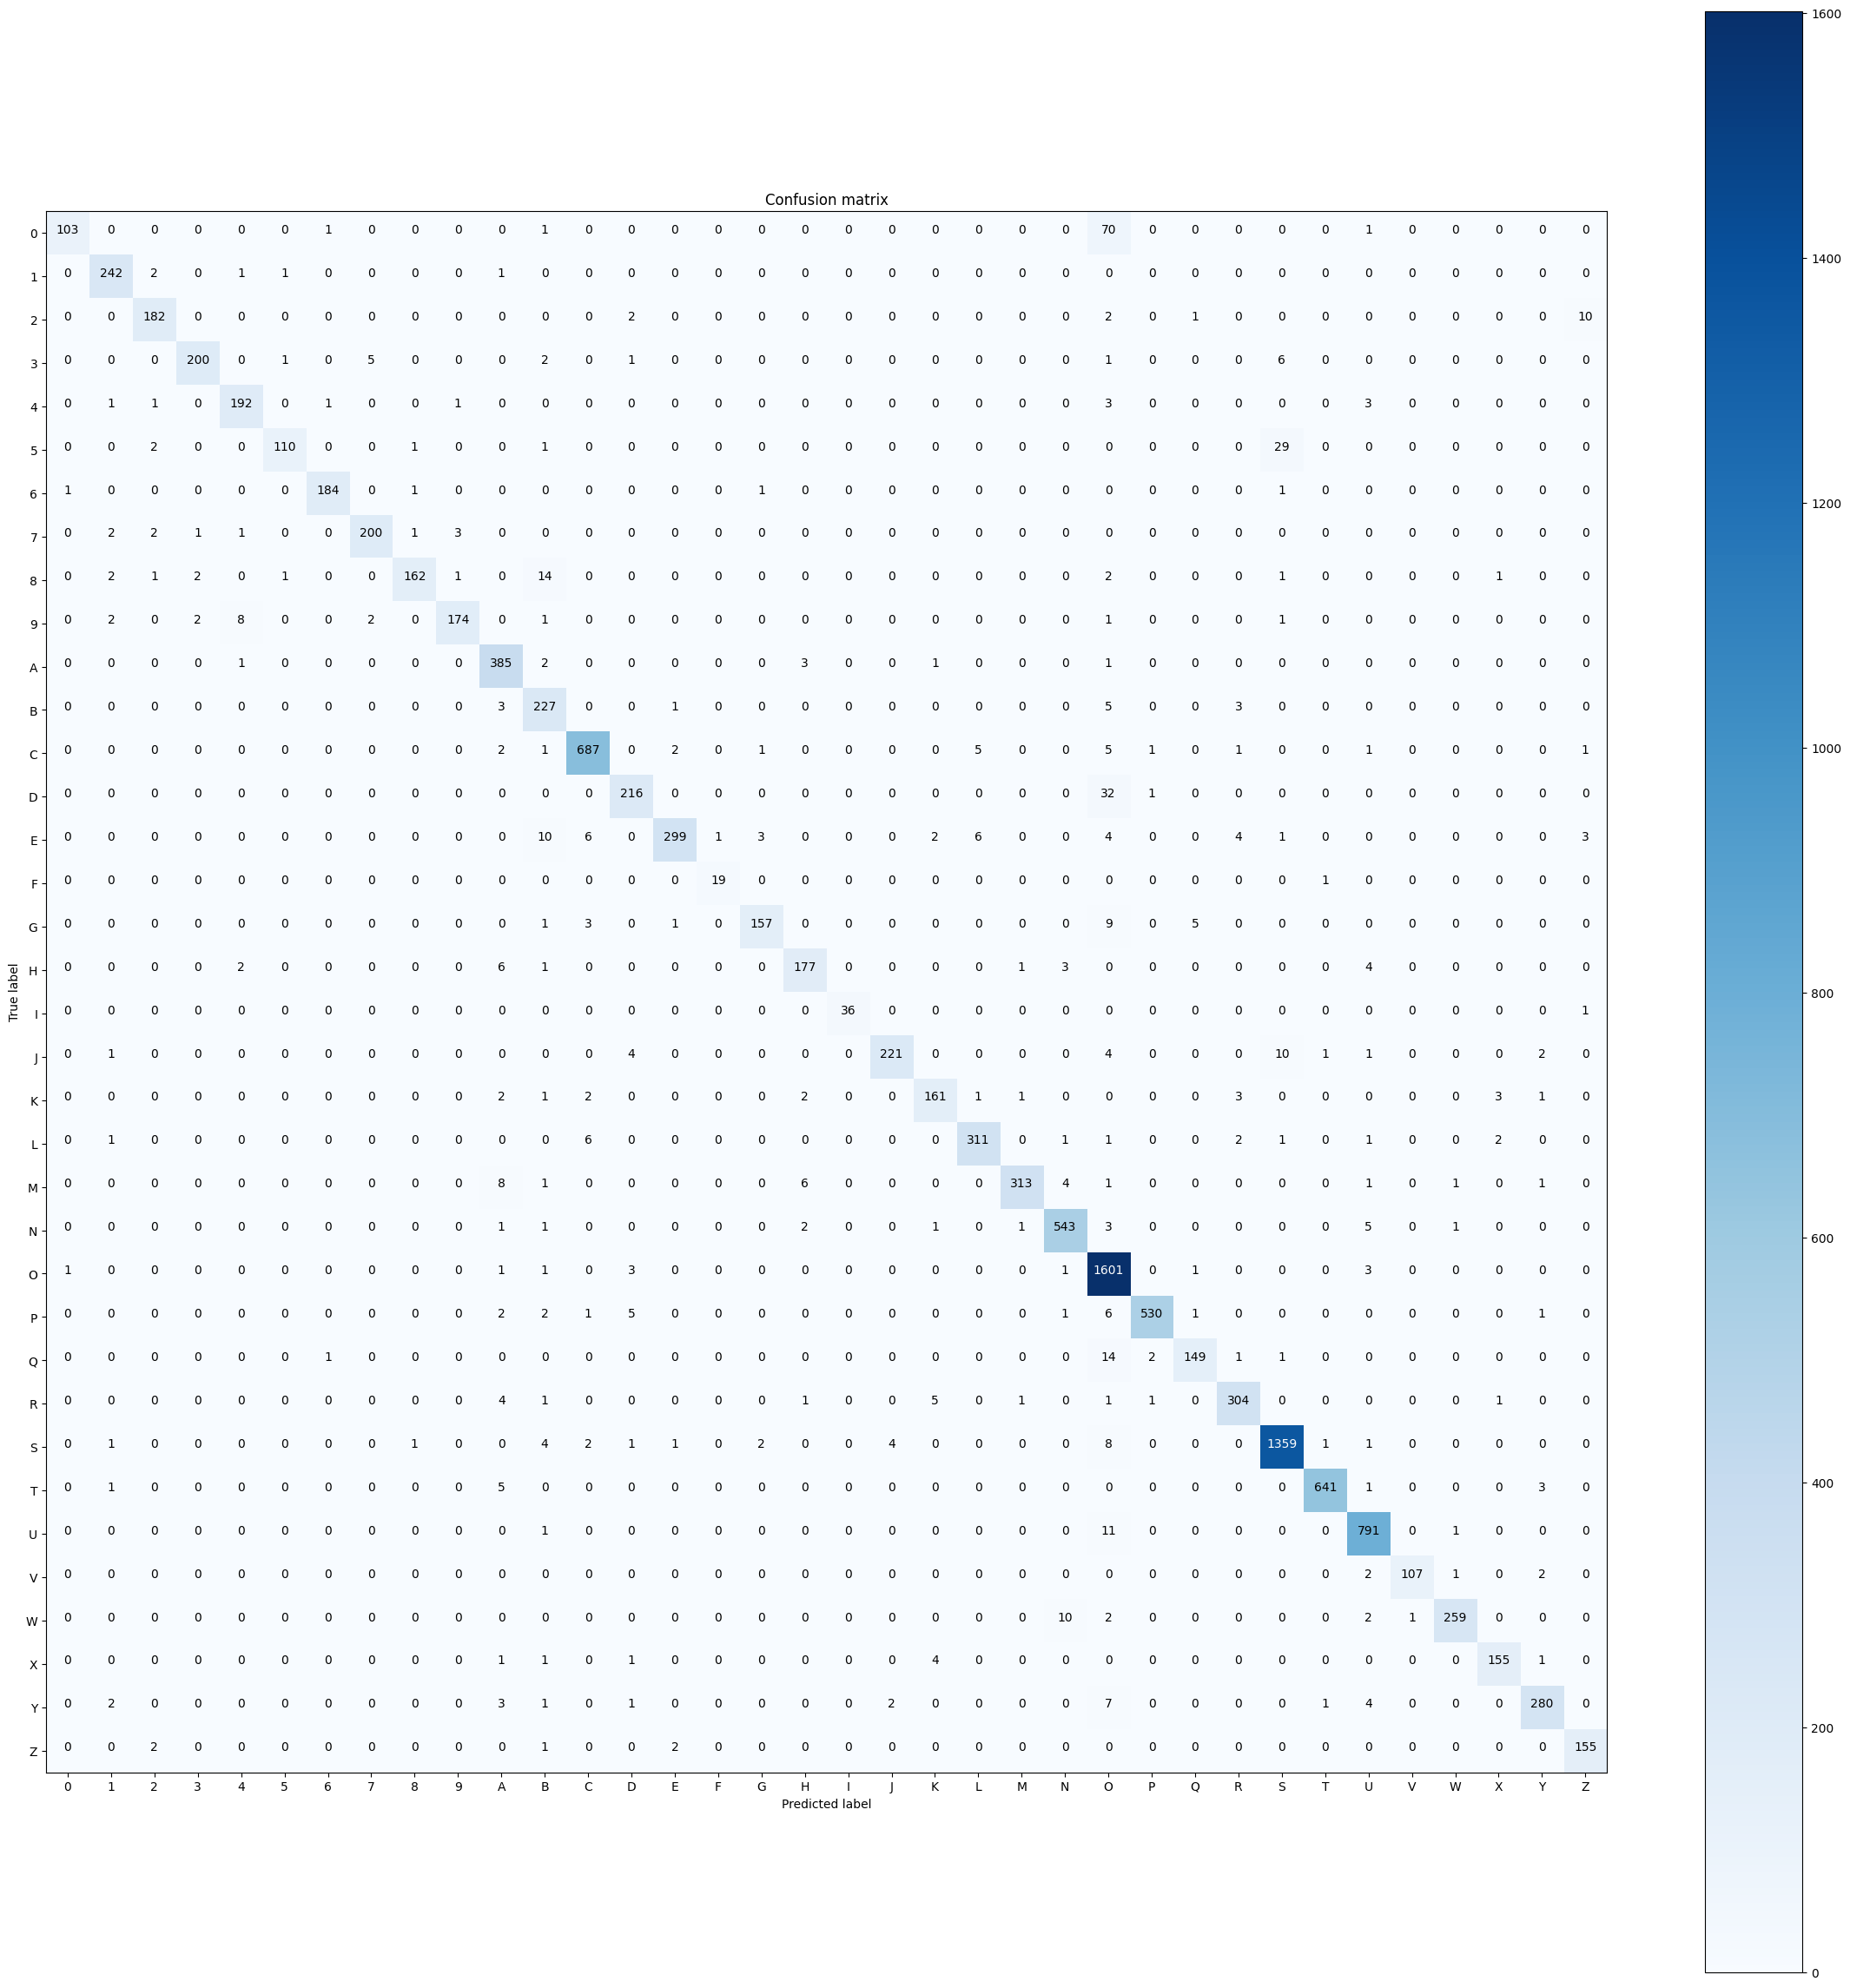

In [46]:
plot_confusion_matrix(cm, classes)

# CNN using Keras

In [47]:
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)

In [48]:
cnn = Sequential([
    
    Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
    
    Conv2D(64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
    
    Flatten(),
    
    Dense(128, activation='relu'),
#     Dropout(0.5),
    Dense(64, activation='relu'),
#     Dropout(0.5),
    Dense(36, activation='softmax')
])

In [49]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)       

In [50]:
cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [51]:
cnn_fit=cnn.fit(X_train_reshaped, Y_train_encoded, epochs=10, validation_data=(X_test_reshaped,Y_test_encoded))

Epoch 1/10
13438/13438 [==============================] - 67s 5ms/step - loss: 0.1751 - accuracy: 0.9497 - val_loss: 0.1314 - val_accuracy: 0.9624
Epoch 2/10
13438/13438 [==============================] - 61s 5ms/step - loss: 0.0821 - accuracy: 0.9760 - val_loss: 0.0888 - val_accuracy: 0.9750
Epoch 3/10
13438/13438 [==============================] - 60s 4ms/step - loss: 0.0615 - accuracy: 0.9816 - val_loss: 0.0642 - val_accuracy: 0.9814
Epoch 4/10
13438/13438 [==============================] - 59s 4ms/step - loss: 0.0490 - accuracy: 0.9851 - val_loss: 0.0608 - val_accuracy: 0.9831
Epoch 5/10
13438/13438 [==============================] - 59s 4ms/step - loss: 0.0401 - accuracy: 0.9875 - val_loss: 0.0553 - val_accuracy: 0.9847
Epoch 6/10
13438/13438 [==============================] - 59s 4ms/step - loss: 0.0341 - accuracy: 0.9891 - val_loss: 0.0559 - val_accuracy: 0.9843
Epoch 7/10
13438/13438 [==============================] - 60s 4ms/step - loss: 0.0296 - accuracy: 0.9905 - val_loss: 0

In [52]:
history = cnn_fit.history

training_loss = history['loss']
validation_loss = history['val_loss']

training_accuracy = history['accuracy']
validation_accuracy = history['val_accuracy']


print("Training Loss:", training_loss)
print("Validation Loss:", validation_loss)
print("Training Accuracy:", training_accuracy)
print("Validation Accuracy:", validation_accuracy)

Training Loss: [0.17508599162101746, 0.0820862427353859, 0.06153395399451256, 0.04900425672531128, 0.040143147110939026, 0.03413275256752968, 0.029588019475340843, 0.02557169273495674, 0.023153414949774742, 0.02205372229218483]
Validation Loss: [0.13138478994369507, 0.08884739875793457, 0.06420104205608368, 0.060757506638765335, 0.055309735238552094, 0.055905070155858994, 0.054486118257045746, 0.05474827066063881, 0.05253373831510544, 0.04522471874952316]
Training Accuracy: [0.9496535062789917, 0.975974440574646, 0.9816465377807617, 0.9850860238075256, 0.9874674677848816, 0.9890744090080261, 0.9905256032943726, 0.9916535019874573, 0.9924418330192566, 0.9928697943687439]
Validation Accuracy: [0.9624096155166626, 0.9750200510025024, 0.981365442276001, 0.983132541179657, 0.9847389459609985, 0.984337329864502, 0.9864256978034973, 0.9864256978034973, 0.9869076013565063, 0.9899598360061646]


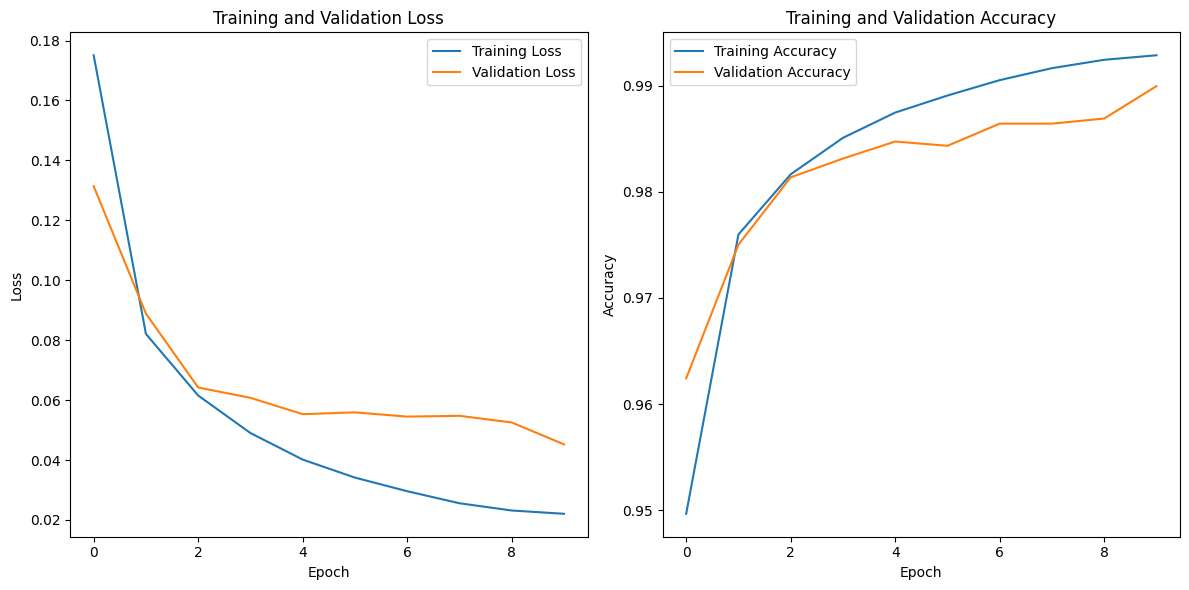

In [53]:
# Plotting the Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
predictions = cnn.predict(X_test_reshaped)
predictions

390/390 [==============================] - 1s 2ms/step


array([[2.1410593e-09, 7.1790818e-10, 4.5246681e-05, ..., 2.0717023e-16,
        8.0404772e-15, 8.0707556e-09],
       [7.4768707e-18, 2.2152714e-20, 3.3658273e-16, ..., 1.5616377e-20,
        2.7614301e-15, 8.9585242e-08],
       [7.4669421e-28, 1.0735614e-23, 4.9729945e-09, ..., 5.2776716e-10,
        1.6263497e-14, 7.4659914e-12],
       ...,
       [1.0405531e-31, 4.0332845e-22, 3.3030811e-28, ..., 3.3685363e-21,
        3.0256627e-11, 1.5703531e-17],
       [3.4590894e-14, 8.5582707e-19, 7.7553233e-12, ..., 2.2325101e-24,
        7.6891181e-23, 9.2239849e-27],
       [7.4121822e-08, 1.9402774e-23, 6.7352805e-18, ..., 3.9806940e-21,
        1.7131095e-11, 3.8749658e-19]], dtype=float32)

In [55]:
Y_test_pred = np.argmax(predictions, axis=1)

In [59]:
cnn_accuracy = get_accuracy(Y_test_pred, Y_test)
cnn_accuracy

[16 11 21 ... 29  8 24] [16 11 21 ... 29  8 24]


0.9899598393574297

In [60]:
cls_report = classification_report(Y_test, Y_test_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       176
           1       0.97      1.00      0.98       247
           2       0.98      0.96      0.97       197
           3       0.99      0.98      0.99       216
           4       0.98      0.97      0.98       202
           5       0.99      0.95      0.97       143
           6       0.99      1.00      1.00       188
           7       0.99      0.99      0.99       210
           8       0.98      0.98      0.98       187
           9       1.00      0.97      0.98       191
          10       0.99      1.00      1.00       393
          11       0.98      0.99      0.99       239
          12       0.99      1.00      0.99       707
          13       1.00      0.97      0.98       249
          14       0.99      0.99      0.99       339
          15       0.91      1.00      0.95        20
          16       1.00      0.99      0.99       176
          17       0.99    

In [61]:
cm = confusion_matrix(y_true = Y_test, y_pred = Y_test_pred)
cm

array([[150,   0,   0, ...,   0,   0,   0],
       [  0, 247,   0, ...,   0,   0,   0],
       [  0,   0, 190, ...,   0,   0,   5],
       ...,
       [  0,   0,   0, ..., 161,   1,   0],
       [  0,   0,   0, ...,   0, 300,   0],
       [  0,   0,   2, ...,   0,   0, 158]])

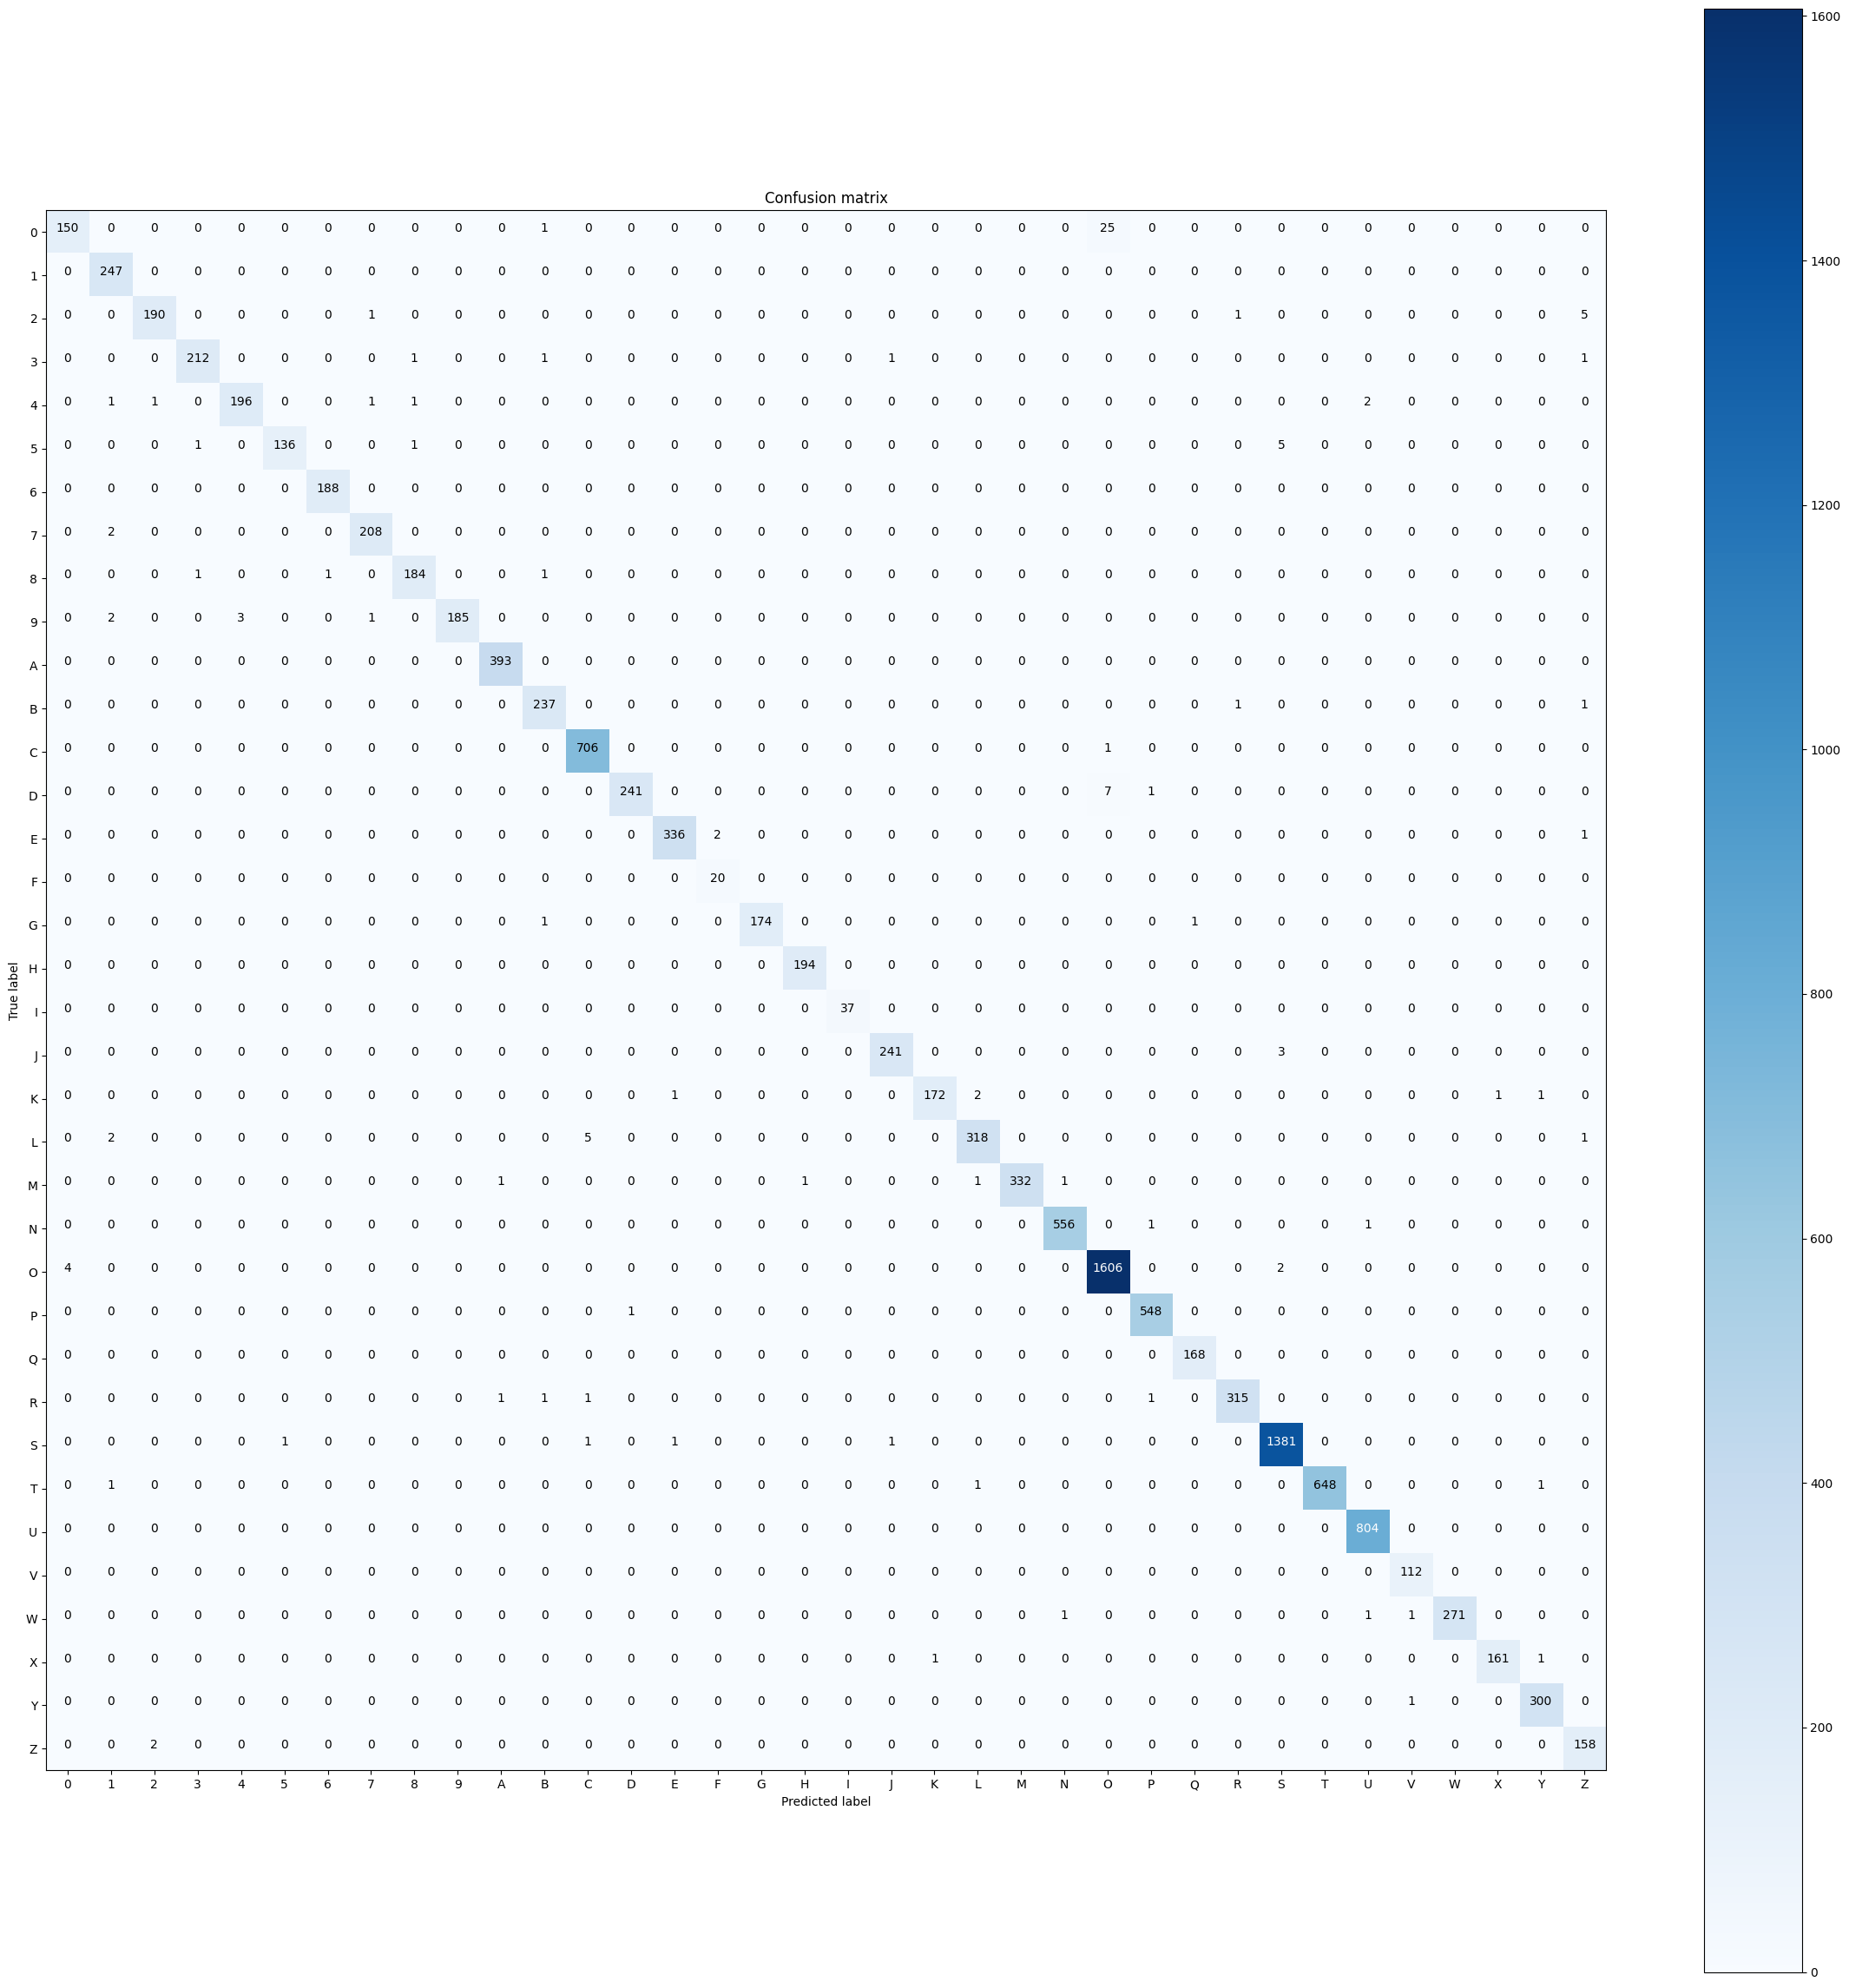

In [63]:
plot_confusion_matrix(cm, classes)

In [66]:
accuracies = [knn_accuracy, ann_accuracy*100, cnn_accuracy*100]
accuracies

[81.18516942390552, 95.03614457831326, 98.99598393574297]

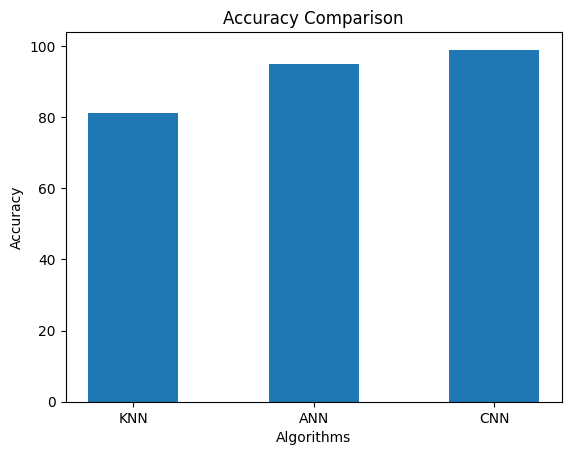

In [67]:
import matplotlib.pyplot as plt
label = ["KNN", "ANN", "CNN"]

plt.bar(label, accuracies, width = 0.5)
plt.title("Accuracy Comparison")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
plt.show()